# Commodity intra-curve

This notebook analyses commodity intra-curve carry strategy. The strategy takes long positions on F3 and short positions on F0. The rationale behind this idea is that commodity producers hedge price risk by selling long-dated futures while commoidty consumers buy short-dated futures to secure near-term consumption. By trading F0 vs F3 one can provide an 'insurance risk premia' to those market participants.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.contract import all_futures_lfis_commodity2015, InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance
from vivace.enums import Strategy, Weighting, RollRule

# Data

22 commodity futures are used as per La Française Group 2015.

In [2]:
all_futures_lfis_commodity2015

,name
ticker,
LX,Zinc
KW,Wheat Kansas
W,Wheat
SB,Sugar
SM,Soybean Meal
BO,Soybean Oil
S,Soybean
SI,Silver
LN,Nickel


In [3]:
all_futures_lfis_commodity2015.shape

(22, 1)

# Performance

## Run backtest

In La Française Group 2015, they report a strategy which buys F3 and sells F0 for each commodity futures. Each futures are equally weighted. However, it is not immediately clear the exact definition of F3 and F0. Here we follow the common definition used in the commodity benchmark space such as BCOM.

In [4]:
instrument = []
for i in all_futures_lfis_commodity2015.index:
    instrument.append(InstrumentDef(i, id=f'{i}_F3', long_or_short=1, forwardness=3, nth_expiry=None, roll_rule=RollRule.FIFTH_BIZ_DAY.value, roll_period=5))
    instrument.append(InstrumentDef(i, id=f'{i}_F0', long_or_short=-1, forwardness=0, nth_expiry=None, roll_rule=RollRule.FIFTH_BIZ_DAY.value, roll_period=5))

In [5]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine.run()

In [6]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False)
                    .rename('Commodity intra-curve portfolio'))

With this very naive configuration, the strategy doesn't seem to be working.

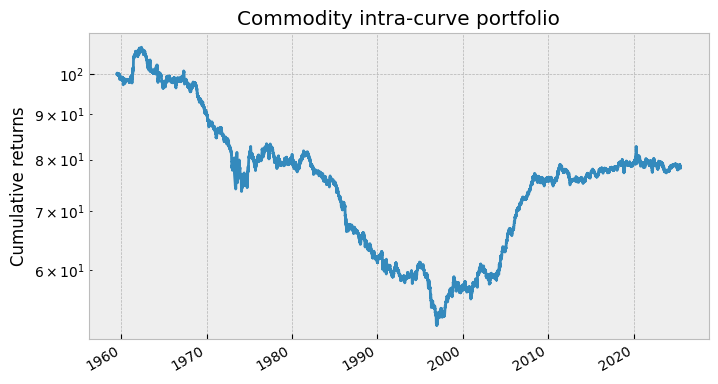

In [7]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('Commodity intra-curve portfolio')
ax.set_ylabel('Cumulative returns');

In [8]:
portfolio_return.pipe(Performance).summary()

,Commodity intra-curve portfolio
CAGR,-0.003652
Annualised vol,0.029805
Sharpe ratio,-0.122532
Max drawdown,0.515959
Calmar ratio,-0.007078
Skewness,0.263858
Kurtosis,18.464766
Worst return,-0.028083
Worst 1d return,-0.028083
Worst 1w return,-0.023046


## Performance decomposition

In [9]:
return_by_commodity = engine.get_return_by_instrument(calculate_net=False)

From the decompositon below, F3 - F0 does not seem to be observed across commodities but only for a few contracts. Furthermore it appears unstable over time even if it had positive returns in the long run. Given the nature of spread trading, certain commodities such as precious metal have much muted realised volatility. Hence they point out that a naive portfolio construction will make the strategy primarily exposed to natural gas.

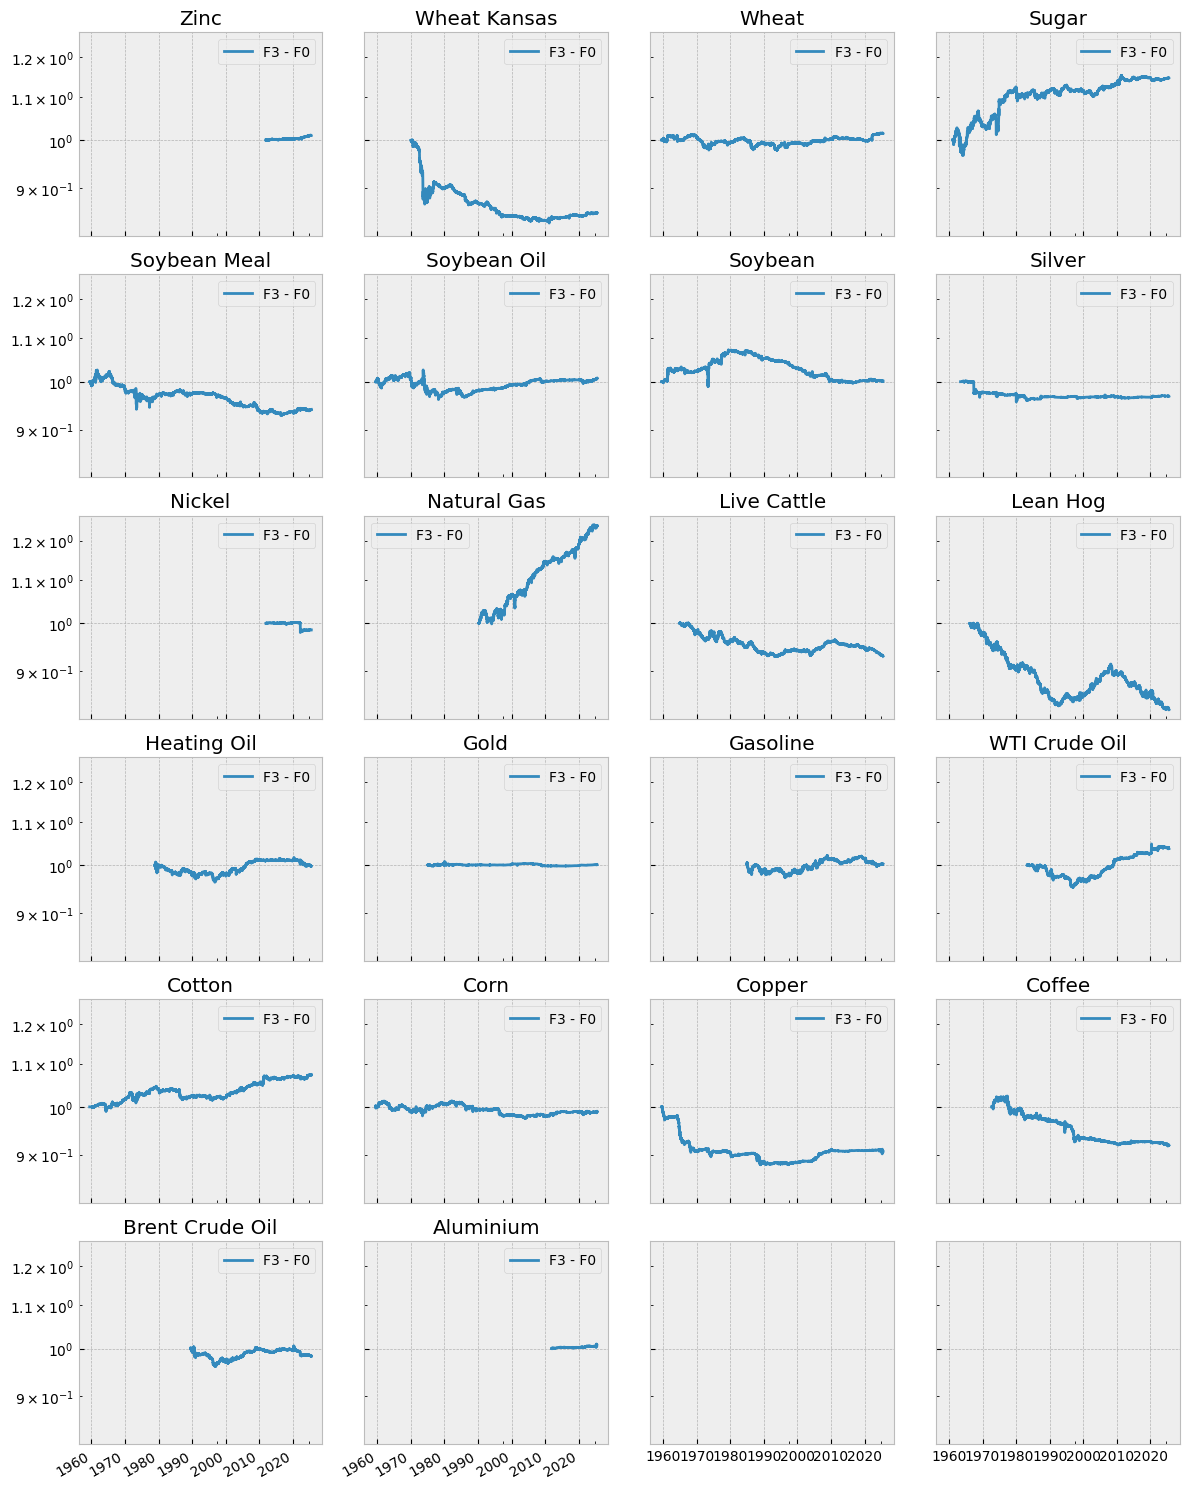

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(12, 15), sharex=True, sharey=True)
ax = ax.flatten()

for idx, i in enumerate(all_futures_lfis_commodity2015.index):
    (return_by_commodity.filter(regex=f'^{i}_').dropna().sum(axis=1).add(1).cumprod()
     .to_frame('F3 - F0')
     .plot(ax=ax[idx], logy=True))
    ax[idx].set_title(all_futures_lfis_commodity2015.at[i, 'name'])
    
    
fig.tight_layout()

## Strategy's risk

In the report, they mention that the spread position (F3 - F0) for certain commodities is exposed to weather and seasonal risk factors. 

In [11]:
def drawdown(ret: pd.Series) -> pd.Series:
    level = ret.add(1).cumprod()
    return level / level.cummax() - 1

def monthly_mdd(instrument: str, start_date: datetime) -> pd.DataFrame:
    result = (return_by_commodity.filter(regex=f'^{instrument}_').sum(axis=1).to_frame('monthly_return')
              [start_date:]
              .assign(
                  year=lambda df: df.index.year,
                  month=lambda df: df.index.month)
              .groupby(['year', 'month'])['monthly_return']
              .apply(lambda x: drawdown(x).min())
              .reset_index()
              .pivot_table('monthly_return', index='year', columns='month'))
    return result

As can be seen below, natural gas tends to have larger drawdowns in winter time which is weather related. 

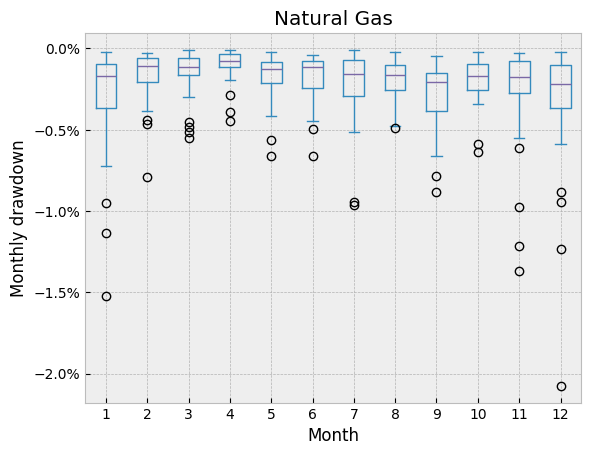

In [12]:
fig, ax = plt.subplots()
monthly_mdd('NG', datetime(1991, 1, 1)).plot(kind='box', showfliers=True, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly drawdown')
ax.set_title(all_futures_lfis_commodity2015.at['NG', 'name'])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=1))

F3 - F0 is essentially a steepener position on the futures curve. In winter time, the front contract can move more drastically than the back end depending on the wheather outcome. In this analysis, the two contracts are weighted dollar neutral and it will hurt the F3-F0 strategy.

In [13]:
ng_f3_settle = engine.get_instrument_leg('NG_F3').get_continuous_settle()
ng_f0_settle = engine.get_instrument_leg('NG_F0').get_continuous_settle()

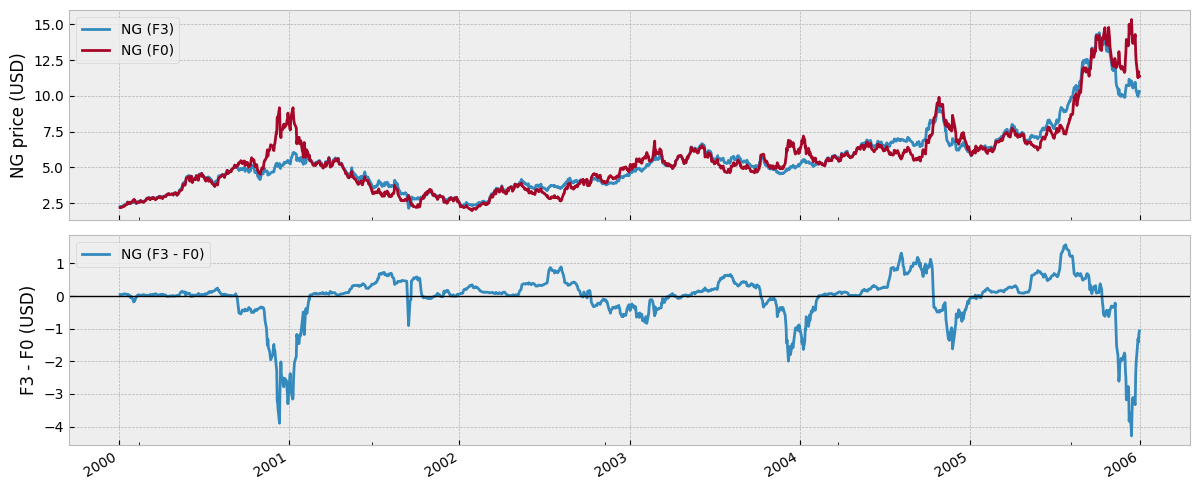

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ng_f3_settle['2000':'2005'].plot(ax=ax[0], label='NG (F3)')
ng_f0_settle['2000':'2005'].plot(ax=ax[0], label='NG (F0)')
(ng_f3_settle - ng_f0_settle)['2000':'2005'].plot(ax=ax[1], label='NG (F3 - F0)')
ax[0].legend()
ax[1].legend()
ax[1].axhline(0, color='black', lw=1)
ax[0].set_ylabel('NG price (USD)')
ax[1].set_ylabel('F3 - F0 (USD)')
fig.tight_layout()

As a result these price moves, the strategy becomes very volatile in winter time and tends to have drawdowns, making it look like a short volatility strategy (it is).

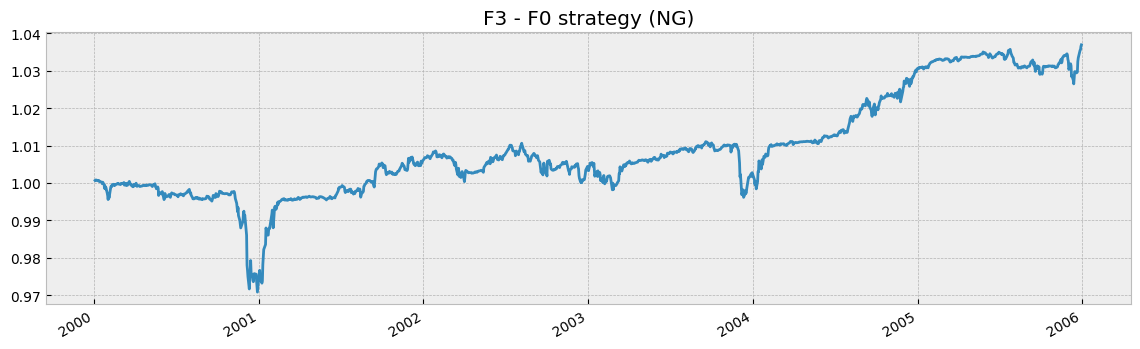

In [15]:
((return_by_commodity.filter(regex=f'^NG_').dropna().sum(axis=1)['2000':'2005'].add(1).cumprod()
  .plot(figsize=(14, 4), title='F3 - F0 strategy (NG)')));

Corn on the other hand has larger risk in spring and the beginning of summer due to the US planting season.

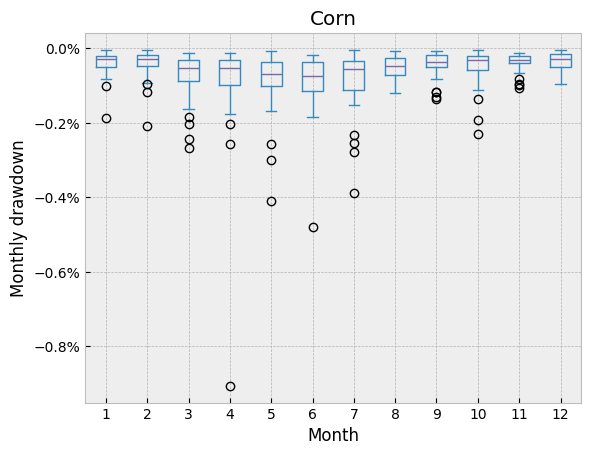

In [16]:
fig, ax = plt.subplots()
monthly_mdd('C', datetime(1991, 1, 1)).plot(kind='box', showfliers=True, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly drawdown')
ax.set_title(all_futures_lfis_commodity2015.at['C', 'name'])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=1))

## Recent performance

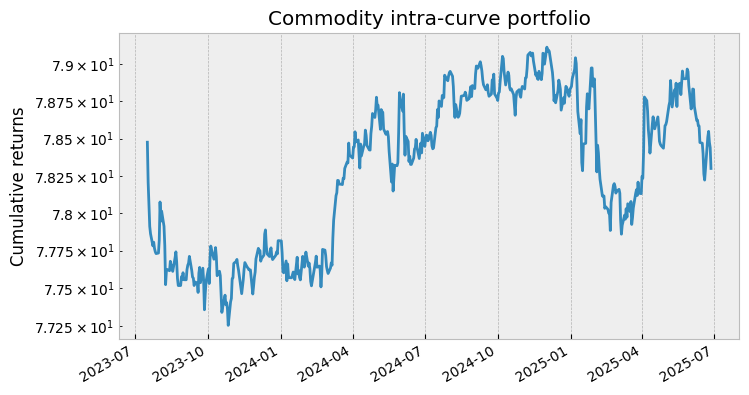

In [17]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('Commodity intra-curve portfolio')
ax.set_ylabel('Cumulative returns');

# Reference
- BCOM Methodology - Bloomberg Professional Services https://assets.bbhub.io/professional/sites/10/BCOM-Methodology-MAR-2022_FINAL.pdf
- La Française Group, 2015, Commodity premia: It’s all about risk control

In [18]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 30-Jun-2025 08:00
